In [58]:
import numpy as np
import matplotlib as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
#python 3.10 pour leur jupyter
data_path = r"C:\Documents\Documents\Projet Data Science\Code Climate Projection\climate-projection-data-science\extracted_contents\\"


var_to_predict =  'tas' #'diurnal_temperature_range', 'tas', 'pr', 'pr90'

Importation + Préparation des données

In [59]:
# Normalise les données (centrées + réduites)
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std


# Prépare les sorties d'entraînement selon le scénario
def output_for_training(Y_train_xr, var, skip_historical=False, len_historical=None): 
    Y_train_np = Y_train_xr[var].data
    # Nombre d'années
    time_length = Y_train_np.shape[0]
    
    # Si on saute les données historiques, on commence par le premier point du scénario
    if skip_historical:
        Y_train_to_return = np.array([[Y_train_np[i+slider-1]] for i in range(len_historical-slider+1, time_length-slider+1)])
    # Sinon on fait tout l'historique + tout le scénario
    else:
        Y_train_to_return = np.array([[Y_train_np[i+slider-1]] for i in range(0, time_length-slider+1)]).astype(np.float32)
    
    return Y_train_to_return


# Prépare les données d'entraînement selon le scénario
def input_for_training(X_train_xr, skip_historical=False, len_historical=None): 
    # On met les dimensions dans le bon ordre
    X_train_np =  X_train_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data 
    # Nombre d'année
    time_length = X_train_np.shape[0] 

    # Si on saute les données historiques, la première séquence a comme dernier point le premier point du scénario
    if skip_historical: 
        X_train_to_return = np.array([X_train_np[i:i+slider] for i in range(len_historical-slider+1, time_length-slider+1)])
    # Sinon on fait tout l'historique + tout le scénario
    else:
        X_train_to_return = np.array([X_train_np[i:i+slider] for i in range(0, time_length-slider+1)]).astype(np.float32)
    
    return X_train_to_return 




# Préparation globale de toutes les données d'entraînement
def prep_data():
    # Ensemble des scénarios d'entraînement
    simus = ['ssp126',
             'ssp370',
             'ssp585',
             'hist-GHG',
             'hist-aer'] 

    X_train = []
    Y_train = []

    for i, simu in enumerate(simus):
        input_name = 'inputs_' + simu + '.nc'
        output_name = 'outputs_' + simu + '.nc'
        
        # Extraction des données historiques
        if 'hist' in simu:
            input_xr = xr.open_dataset(data_path + input_name)

            output_xr = xr.open_dataset(data_path + output_name).mean(dim='member')
            # Conversion en mm/jour pour les précipitations
            output_xr = output_xr.assign({
                "pr": output_xr.pr * 86400,
                "pr90": output_xr.pr90 * 86400
            }).rename({'lon': 'longitude', 'lat': 'latitude'}).transpose('time', 'latitude', 'longitude').drop_vars(['quantile'])
        

        # Extraction des données avec scénarios (concaténation historique + prévision)
        else:
            input_xr = xr.open_mfdataset([data_path + 'inputs_historical.nc',
                                          data_path + input_name]).compute()

            output_xr = xr.concat([
                xr.open_dataset(data_path + 'outputs_historical.nc').mean(dim='member'),
                xr.open_dataset(data_path + output_name).mean(dim='member')],
                dim='time').compute()
            
            # Conversion en mm/jour pour les précipitations
            output_xr = output_xr.assign({
                "pr": output_xr.pr * 86400,
                "pr90": output_xr.pr90 * 86400
            }).rename({'lon': 'longitude', 'lat': 'latitude'}).transpose('time', 'latitude', 'longitude').drop_vars(['quantile'])


        # On moyenne spatialement les gaz à effet de serre longue durée s'il sont en 3D
        for var in ['CO2', 'CH4']:
            if set(input_xr[var].dims) == {'time', 'latitude', 'longitude'}:
                var_data = input_xr[var].data
                if np.allclose(var_data, var_data[:, 0:1, 0:1]):
                    reduced = var_data[:, 0, 0]
                    input_xr[var] = xr.DataArray(
                        reduced,
                        dims=["time"],
                        coords={"time": input_xr["time"]},
                        name=var,
                        attrs=input_xr[var].attrs
                    )
        
        # Création des ensembles d'entraînements bruts pour chaque scénario
        X_train.append(input_xr)
        Y_train.append(output_xr)
    
    # On calcule la moyenne et l'écart-type pour chaque variable sur tous les scénarios concaténés
    for var in ['CO2', 'CH4', 'SO2', 'BC']:
        # On exclue la période historique pour ssp370 et ssp585
        array = np.concatenate(
            [X_train[i][var].data for i in [0, 3, 4]] +
            [X_train[i][var].sel(time=slice(len_historical, None)).data for i in range(1, 3)]
        )
        meanstd_inputs[var] = (array.mean(), array.std())

    X_train_norm = []
    
    # On normalise les données scénario par scénario
    for i, train_xr in enumerate(X_train):
        for var in ['CO2', 'CH4', 'SO2', 'BC']:
            var_dims = train_xr[var].dims
            train_xr = train_xr.assign({var: (var_dims, normalize(train_xr[var].data, var, meanstd_inputs).astype(np.float32))})
        X_train_norm.append(train_xr)
    
    # Data set d'entrée complet : array numpy (nbr_séquences, slider, lat, lon, nbr_variables)
    X_train_all = np.concatenate([
        input_for_training(X_train_norm[i], skip_historical=(i < 2), len_historical=len_historical)
        for i in range(len(simus))
    ], axis=0)
    
    # Data set de sortie complet : array numpy (nbr_séquences, 1)
    Y_train_all = np.concatenate([
        output_for_training(Y_train[i], var_to_predict, skip_historical=(i < 2), len_historical=len_historical)
        for i in range(len(simus))
    ], axis=0)

    return (X_train_all, Y_train_all)


In [60]:
# On prend des échantillons de 5 ans
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
len_historical = 165
meanstd_inputs = {}
slider = 10
print("Importation...")

# Importation et préparation des données d'entraînement
X_train_all, Y_train_all = prep_data()

Importation...


In [61]:
## Préparation des données de test, séparation scalaire/spatial et passage en tenseurs PyTorch (sauf les sorties de test) ##

# Import des données d'entrée de test
x_true_norm = xr.open_mfdataset([data_path + 'inputs_historical.nc',
                                 data_path + 'inputs_ssp245.nc']).compute()

# Normalisation des données d'entrée de test
for var in ['CO2', 'CH4', 'SO2', 'BC']:
    var_dims = x_true_norm[var].dims
    x_true_norm = x_true_norm.assign({var: (var_dims, normalize(x_true_norm[var].data, var, meanstd_inputs))})

# Prétraitement des données d'entrée de test
X_test_np = input_for_training(x_true_norm, skip_historical=False, len_historical=len_historical)
x_input_tensor = torch.from_numpy(X_test_np).float().to(device)

# Détermination de l'ordre des variables
feature_order = list(x_true_norm.to_array().coords['variable'].values)
idx_spatial = [i for i, v in enumerate(feature_order) if v in ['SO2', 'BC']]
idx_scalar  = [i for i, v in enumerate(feature_order) if v in ['CO2', 'CH4']]

# Tenseurs d'entraînement en PyTorch
X_tensor = torch.from_numpy(X_train_all).float()
Y_tensor = torch.from_numpy(Y_train_all).float()

X_spatial_all = X_tensor[..., idx_spatial]             # (N, T, 96, 144, 2)
X_scalar_all  = X_tensor[..., 0, 0, idx_scalar]        # (N, T, 2)

# Tenseur test aussi
x_spatial_tensor = x_input_tensor[..., idx_spatial]    # (N, T, 96, 144, 2)
x_scalar_tensor  = x_input_tensor[..., 0, 0, idx_scalar]  # (N, T, 2)

# Empaquetage des données au sein d'une instance en séparant données spatiales (SO2, BC) et données scalaires (CO2, CH4)
class DualInputWrapper(torch.utils.data.Dataset):
    def __init__(self, spatial, scalar, target):
        self.spatial = spatial
        self.scalar = scalar
        self.target = target

    def __len__(self):
        return len(self.spatial)

    def __getitem__(self, idx):
        return (self.spatial[idx], self.scalar[idx]), self.target[idx]

full_dataset = DualInputWrapper(X_spatial_all, X_scalar_all, Y_tensor)

# Import des données de sorties de test
y_true = xr.open_mfdataset([data_path + 'outputs_historical.nc',
                            data_path + 'outputs_ssp245.nc'])['tas'].to_numpy().mean(axis=0)



In [62]:
print("\n--- Dimensions dans x_true_norm ---")
for var in ['CO2', 'CH4', 'SO2', 'BC']:
    print(f"{var:>4} : dims={x_true_norm[var].dims}, shape={x_true_norm[var].shape}")

print("\n--- Shape de X_test_np ---")
print(f"X_test_np shape : {X_test_np.shape}")  # (n_samples, slider, x, y, n_features)

print("\n--- Ordre réel des variables dans X_test_np ---")
feature_names = list(x_true_norm.to_array().coords['variable'].values)
for i, var in enumerate(feature_names):
    print(f"Index {i} → {var}")


--- Dimensions dans x_true_norm ---
 CO2 : dims=('time',), shape=(251,)
 CH4 : dims=('time',), shape=(251,)
 SO2 : dims=('time', 'latitude', 'longitude'), shape=(251, 96, 144)
  BC : dims=('time', 'latitude', 'longitude'), shape=(251, 96, 144)

--- Shape de X_test_np ---
X_test_np shape : (242, 10, 96, 144, 4)

--- Ordre réel des variables dans X_test_np ---
Index 0 → CO2
Index 1 → SO2
Index 2 → CH4
Index 3 → BC


Entraînement + Prédiction

In [63]:
# On entraîne le réseau de neurones (construit plus loin)
def train(epochs, model, train_loader, criterion, optimizer, device):
    # Suivi visuel de l'entraînement
    epoch_bar = tqdm(range(epochs), desc="Entraînement", unit="epoch")

    for epoch in epoch_bar:
        model.train()
        train_loss = 0.0
        #On boucle sur les batchs
        for (X_spatial, X_scalar), Y_batch in train_loader:
            X_spatial = X_spatial.to(device)
            X_scalar = X_scalar.to(device)
            Y_batch = Y_batch.to(device)
            # Rétropropagation
            optimizer.zero_grad()
            outputs = model(X_spatial, X_scalar)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_spatial.size(0)
        # On moyenne l'erreur d'entraînement sur toutes les dates
        train_loss /= len(train_loader.dataset)
        epoch_bar.set_postfix(loss=f"{train_loss:.4f}")


# On utilise le modèle entraîné pour prédire les sorties de test
def pred(model):   
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(x_spatial_tensor, x_scalar_tensor)
    y_pred_np = y_pred_tensor.cpu().numpy().squeeze(1)
    return y_pred_np


Métrique + Evaluation

In [64]:
# Pondère le fait que une surface projeté près de l'équateur représente plus de surface réelle que près des pôles
def cosine_weighted_spatial_mean(x):
    lat_dim = x.shape[-2]
    lon_dim = x.shape[-1]

    # Génère les latitudes
    latitudes = np.linspace(-90, 90, lat_dim)
    lat_radians = np.radians(latitudes)

    # Poids cosinus
    weights = np.cos(lat_radians)  # shape: (lat,)
    weights_2d = weights[:, np.newaxis]  # shape: (lat, 1)

    # Broadcasting : ajoute les dimensions d'alignement
    while weights_2d.ndim < x.ndim:
        weights_2d = np.expand_dims(weights_2d, axis=0)

    # Produit pondéré
    weighted = x * weights_2d  # Broadcasting automatique

    # Moyenne spatiale pondérée
    spatial_mean = weighted.sum(axis=(-2, -1)) / (lat_dim * lon_dim)

    return spatial_mean

# Ecart dans le temps des données moyennées spatialement
def compute_nrmse_g(Y_pred, Y_true, T=20):
    # Sélection des 20 dernières années
    Y_pred_20 = Y_pred[-T:]
    Y_true_20 = Y_true[-T:]
    numerator = np.sqrt(np.mean((cosine_weighted_spatial_mean(Y_pred_20) - cosine_weighted_spatial_mean(Y_true_20))**2))
    denominator = np.abs(np.mean(cosine_weighted_spatial_mean(Y_true_20)))

    return numerator / denominator

# Ecart spatial des données moyennées temporellement
def compute_nrmse_s(Y_pred, Y_true, T=20):
    # Sélection des 20 dernières années
    Y_pred_20 = Y_pred[-T:]
    Y_true_20 = Y_true[-T:]
    numerator= np.sqrt(cosine_weighted_spatial_mean((np.mean(Y_pred_20,axis=0)-np.mean(Y_true_20,axis=0))**2))
    denominator = np.abs(np.mean(cosine_weighted_spatial_mean(Y_true_20)))
    return numerator / denominator


# Evaluation de la prédiction
def eval(batch_size, learning_rate, lambda_l2, epochs, criterion, model):
    train_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

    train(epochs, model, train_loader, criterion, optimizer, device)
    y_pred = pred(model)

    NRMSE_g = compute_nrmse_g(y_pred, y_true)
    NRMSE_s = compute_nrmse_s(y_pred, y_true)
    NRMSE_t = 5 * NRMSE_g + NRMSE_s
        
    return (NRMSE_g, NRMSE_s, NRMSE_t, y_pred)

Fonction de perte pondérée par les cosinus

In [65]:
class LatitudeWeightedMSELoss(nn.Module):    
    def __init__(self, n_lat=96, lat_range=(-90, 90), device='cpu'):
        super(LatitudeWeightedMSELoss, self).__init__()


        # Create the cosine weighting vector for latitude
        latitudes = torch.linspace(lat_range[0], lat_range[1], steps=n_lat, device=device)
        self.weights = torch.cos(torch.deg2rad(latitudes)).view(1, 1, n_lat, 1)  # shape: (1, 1, lat, 1)


    def forward(self, prediction, target):
        """
        prediction and target should have shape: (batch, channels, lat, lon)
        """
        assert prediction.shape == target.shape, "Prediction and target must have the same shape"


        # Compute squared error
        squared_error = (prediction - target) ** 2


        # Apply latitude weights
        weighted_error = squared_error * self.weights  # broadcast over batch and channel


        # Return mean over all elements
        return weighted_error.mean()

Paramètres

In [66]:
batch_size = 16
epochs = 30
learning_rate = 1e-3
criterion = LatitudeWeightedMSELoss()
lambda_l2 = 1e-7

Modèle : Réseau de neurones initial avec GRU et CO2/CH4 scalaires

In [ ]:
class CNNGRU(nn.Module):
    def __init__(self):
        super(CNNGRU, self).__init__()
        
        # Convolution sur les données spatiales (2 canaux : SO2, BC)
        self.conv2d = nn.Conv2d(in_channels=2, out_channels=20, kernel_size=3, padding=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # => (batch*time, 20, 1, 1)

        self.scalar_weights = nn.Parameter(torch.randn(2, 20))
        nn.init.xavier_uniform_(self.scalar_weights)
        
        # GRU : 20 (spatial features) + 2 (scalaires) = 22 dim en entrée
        self.gru = nn.GRU(input_size=20, hidden_size=40, batch_first=True)
        self.fc = nn.Linear(40, 96 * 144)

    def forward(self, x_spatial, x_scalar):
        # x_spatial: (B, T, 96, 144, 2)
        # x_scalar:  (B, T, 2)
        B, T, H, W, nbr_spatial = x_spatial.shape

        # Préparer pour la convolution : (B*T, C, H, W)
        x_spatial = x_spatial.permute(0, 1, 4, 2, 3).contiguous().view(B * T, nbr_spatial, H, W)
        x_spatial = F.relu(self.conv2d(x_spatial))
        x_spatial = self.global_avg_pool(x_spatial)
        x_spatial = x_spatial.view(B, T, -1)  # (B, T, 20)
        
        # Intégrer les données scalaires
        x_scalar_combined = torch.einsum('btd,df->btf', x_scalar, self.scalar_weights)  # (B, T, 20)
        x = x_spatial + x_scalar_combined

        # GRU
        x, _ = self.gru(x)
        x = x[:, -1, :]  # Dernier pas de temps

        x = self.fc(x)  # (B, 96*144)
        x = x.view(B, 1, 96, 144)
        return x

summary(
    CNNGRU(),
    input_data={
        "x_spatial": torch.zeros(16, 10, 96, 144, 2),  # SO2 + BC
        "x_scalar": torch.zeros(16, 10, 2)             # CO2 + CH4
    },
    col_names=["input_size", "output_size", "num_params"],
    depth=4,
    verbose=1
)

Entraînement + évaluation (moyennée sur 10 entraînements)

In [70]:
nbr_entraînements = 10

liste_g, liste_s, liste_t = [], [], []
for run in range(nbr_entraînements):
    print(f"Entraînement n°{run + 1}")
    NRMSE_g, NRMSE_s, NRMSE_t, y_pred = eval(batch_size, learning_rate, lambda_l2, epochs, criterion, CNNGRU().to(device))
    liste_g.append(NRMSE_g)
    liste_s.append(NRMSE_s)
    liste_t.append(NRMSE_t)
print(f"NRMSE_g : {np.mean(liste_g)} +/- {np.std(liste_g)}") 
print(f"NRMSE_s : {np.mean(liste_s)} +/- {np.std(liste_s)}")
print(f"NRMSE_t : {np.mean(liste_t)} +/- {np.std(liste_t)}")

print(f"Liste des NRMSE_t sur 10 entraînements : {liste_t}")

Entraînement n°1


Entraînement:   0%|          | 0/30 [00:00<?, ?epoch/s]


KeyboardInterrupt: 

Tracés des cartes

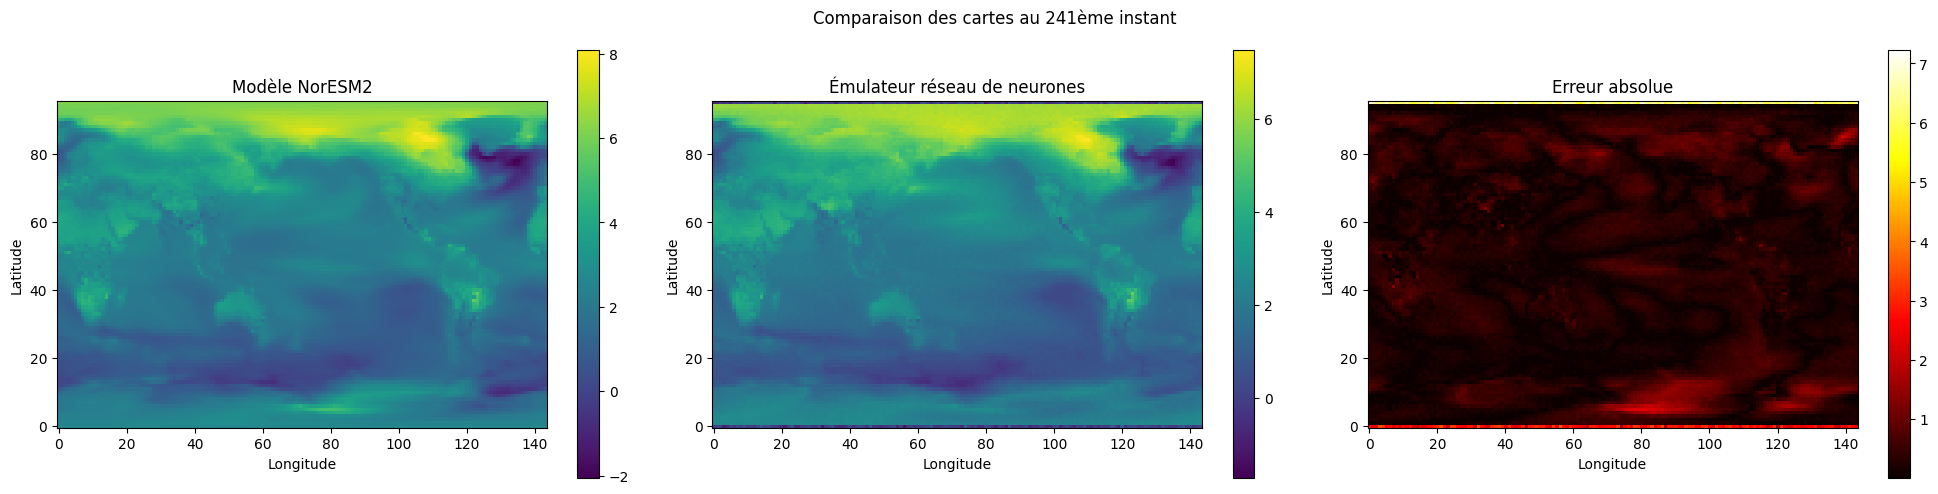

In [ ]:
sequence_index = 241

true_map = y_true[sequence_index]
predicted_map = y_pred[sequence_index]
error_map = np.abs(true_map - predicted_map)

fig, axes = plt.subplots(1, 3, figsize = (20,5))

image_1 = axes[0].imshow(true_map, cmap = "viridis", origin = "lower")
axes[0].set_title("Modèle NorESM2")
plt.colorbar(image_1, ax=axes[0])

image_2 = axes[1].imshow(predicted_map, cmap = "viridis", origin = "lower")
axes[1].set_title("Émulateur réseau de neurones")
plt.colorbar(image_2, ax=axes[1])

image_3 = axes[2].imshow(error_map, cmap = "hot", origin = "lower")
axes[2].set_title("Erreur absolue")
plt.colorbar(image_3, ax=axes[2])


for ax in axes :
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")


plt.suptitle(f"Comparaison des cartes au {sequence_index}ème instant")
plt.tight_layout()
plt.show()